In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Importing required libraries
from __future__ import print_function

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import os
import pycbc
from pycbc import distributions
from pycbc import inference
from pycbc.inference import models

pycbc.init_logging(True)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# Setting prior distribution

**A prior distribution is a probability distribution that represents a researcher's beliefs about the parameter(s) of interest before any data is observed.**

**In Bayesian statistics, the prior distribution is combined with the likelihood function of the data to obtain the posterior distribution, which reflects the updated beliefs about the parameter(s) after observing the data.**

In [3]:
xdist = distributions.Uniform(x = (-10, 10))
ydist = distributions.Uniform(y = (-10, 10))

**We need to create a Joint Distribution to handle the two distributions.**

In [4]:
jointdist = distributions.JointDistribution(["x", "y"], xdist, ydist)

# Setting up the model

**We now create a "model" instance. We will tell it that it has two parameters, called "x" and "y", and we provide the "jointdistribution" as prior.**

In [5]:
model = models.models["test_normal"](["x", "y"], prior = jointdist)

**The "model" can produce a random draws from the prior.**

In [6]:
random_draws = model.prior_rvs(size = 3)
print("x: ", random_draws['x'])
print("y: ", random_draws['y'])

test_point_x = random_draws["x"][0]
test_point_y = random_draws["y"][0]

print(test_point_x, test_point_y)

x:  [-0.38047805 -7.55471781 -6.62329492]
y:  [-1.18014212 -6.7328735  -8.92046578]
-0.3804780468617075 -1.1801421152550606


In [7]:
model.update(x = test_point_x, y = test_point_y)

**Now, we get the "logprior" and "loglikelihood" values by calling the appropriate attributes.**

In [8]:
print("logprior at point: ", model.logprior)
print("loglikelihood at point: ", model.loglikelihood)

logprior at point:  -5.991464547107982
loglikelihood at point:  -2.6066265445805397


**Or, we can call "logposterior", which is the sum of the "logprior" and "loglikelihood" values:**

In [9]:
model.logposterior

-8.598091091688522

**When the sample runs, it calls "model.update" for each new point it wants to test, then gets the statistics it needed."**

# Set up the sampler

**With model initialized we can now set up the sampler.**

## Initializer

In [10]:
sampler = inference.sampler.emcee.EmceeEnsembleSampler(model, nwalkers = 1000, checkpoint_interval = 100, nprocesses = 8)

## Set up output file

**We need to provide an output file that the sampler can write the samples to.<br>The function setup_output in pycbc.inference.sampler.base takes care of setting up a fresh output file for us, and setting the necessary sampler attributes.<br>We'll call the file normal2d.hdf.<br>The function setup_output will actually create a file called normal2d.hdf.checkpoint, and normal2.hdf.bkup.<br>Results are written to these files every time the sampler checkpoints, which for emcee occurs after the sampler has run for checkpoint_interval iterations.**

In [11]:
output_filename = "normal2d.hdf"

# if the checkpoint file already exists, the sampler will try to
# load that file and run from it; since we want a fresh run here,
# we first need to remove it
for ftype in ['.checkpoint', '.bkup']:
    fname = output_filename + ftype
    
    if os.path.exists(fname):
        os.remove(fname)
    
# Now setup the output file
inference.sampler.base.setup_output(sampler, output_file = output_filename)

2023-04-06T00:04:55.641-04:00 Looking for checkpoint file
2023-04-06T00:04:55.643-04:00 Checkpoint not found or not valid
2023-04-06T00:04:55.644-04:00 Creating file normal2d.hdf.checkpoint


### Setting the termination condition

**We will run for 200 iterations**

In [12]:
sampler.set_target(200)

### Set the starting point

**For the emcee sampler "(and all of the MCMC samplers)", we need to set a starting position for all of the walkers/chains. We can do this by calling sampler.set_p0(). If we provide "no arguments", this "will draw random samples from the prior distribution".<br>Alternatively, "if we want to set the starting positions using a different distribution than the prior", we could provide a "prior argument" to this function and point it at a different JointDistribution instance.**

In [13]:
_ = sampler.set_p0()

### Run the sampler

In [14]:
sampler.run()

2023-04-06T00:04:55.699-04:00 Running sampler for 0 to 100 iterations
2023-04-06T00:04:58.715-04:00 Writing samples to normal2d.hdf.checkpoint with thin interval 1
2023-04-06T00:04:58.777-04:00 Writing samples to normal2d.hdf.bkup with thin interval 1
2023-04-06T00:04:58.841-04:00 Computing autocorrelation time
2023-04-06T00:04:59.022-04:00 ACT: 11
2023-04-06T00:04:59.083-04:00 Validating checkpoint and backup files
2023-04-06T00:04:59.110-04:00 Clearing samples from memory
2023-04-06T00:04:59.126-04:00 Running sampler for 100 to 200 iterations
2023-04-06T00:05:02.086-04:00 Writing samples to normal2d.hdf.checkpoint with thin interval 1
2023-04-06T00:05:02.151-04:00 Writing samples to normal2d.hdf.bkup with thin interval 1
2023-04-06T00:05:02.226-04:00 Computing autocorrelation time
2023-04-06T00:05:02.346-04:00 ACT: 13
2023-04-06T00:05:02.383-04:00 Validating checkpoint and backup files
2023-04-06T00:05:02.414-04:00 Clearing samples from memory


# Plotting the results

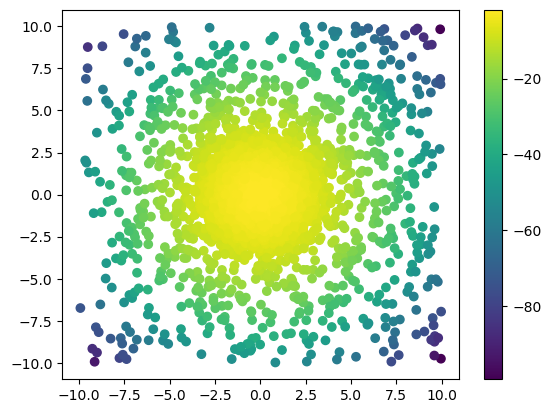

In [15]:
fp = inference.io.loadfile("normal2d.hdf.checkpoint", "r")
samples = fp.read_samples(['x', 'y', 'loglikelihood'])

plt.figure()
plt.scatter(samples['x'], samples['y'], c = samples['loglikelihood'])
plt.colorbar()

plt.show()

fp.close()